# Texas Inpatient Discharg - Model

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import streamlit as st
import numpy as np
import pandas as pd
import joblib

from scipy import stats
import yaml, time, sys, os, glob

import seaborn as sns
sns.set_style("darkgrid")

from IPython.display import display, Markdown
pd.set_option('display.max_columns', None)  

DATASET = "Texas_Inpatient_Discharge"
SPLIT_TRAINING = True
DEBUG = False
SEED = 42

COLAB = 'google.colab' in sys.modules
if COLAB:
    ROOT = f"/content/gdrive/MyDrive/datasets/{DATASET.replace(' ','_')}/"
else:
    ROOT = "./"

In [45]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV


from sklearn.impute import SimpleImputer

from sklearn.preprocessing import OneHotEncoder , StandardScaler
from sklearn.feature_selection import SelectPercentile, chi2, RFECV

#from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier,StackingClassifier

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import GridSearchCV, cross_val_score

In [46]:
df = pd.read_pickle(f"{ROOT}/data/df_train_preprocess_00_of_10.pkl")
print(df.shape)
df.head()

(99969, 40)


,TYPE_OF_ADMISSION,SOURCE_OF_ADMISSION,PAT_STATE,PAT_COUNTRY,PUBLIC_HEALTH_REGION,SEX_CODE,RACE,ETHNICITY,ADMIT_WEEKDAY,TARGET,PROVIDER_NAME_col_0,PROVIDER_NAME_col_1,PROVIDER_NAME_col_2,PROVIDER_NAME_col_3,PROVIDER_NAME_col_4,PROVIDER_NAME_col_5,PROVIDER_NAME_col_6,COUNTY_col_0,COUNTY_col_1,COUNTY_col_2,COUNTY_col_3,COUNTY_col_4,COUNTY_col_5,COUNTY_col_6,ADMITTING_DIAGNOSIS_col_0,ADMITTING_DIAGNOSIS_col_1,ADMITTING_DIAGNOSIS_col_2,ADMITTING_DIAGNOSIS_col_3,ADMITTING_DIAGNOSIS_col_4,ADMITTING_DIAGNOSIS_col_5,ADMITTING_DIAGNOSIS_col_6,PRINC_DIAG_CODE_col_0,PRINC_DIAG_CODE_col_1,PRINC_DIAG_CODE_col_2,PRINC_DIAG_CODE_col_3,PRINC_DIAG_CODE_col_4,PRINC_DIAG_CODE_col_5,PRINC_DIAG_CODE_col_6,POA_OTH_DIAG_CODE_COUNT,POA_E_CODE_COUNT
992358,1,1,TX,US,03,M,4,2,6,2,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,8,0
900799,1,1,TX,US,11,F,4,1,4,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,14,0
770151,1,1,TX,US,11,M,4,1,6,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,11,0
762640,1,1,TX,US,07,F,2,1,6,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,13,0
896831,4,5,TX,US,08,M,4,2,4,2,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99969 entries, 992358 to 935287
Data columns (total 40 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   TYPE_OF_ADMISSION          99969 non-null  category
 1   SOURCE_OF_ADMISSION        99969 non-null  category
 2   PAT_STATE                  99969 non-null  category
 3   PAT_COUNTRY                99969 non-null  category
 4   PUBLIC_HEALTH_REGION       99969 non-null  category
 5   SEX_CODE                   99969 non-null  category
 6   RACE                       99969 non-null  category
 7   ETHNICITY                  99969 non-null  category
 8   ADMIT_WEEKDAY              99969 non-null  category
 9   TARGET                     99969 non-null  category
 10  PROVIDER_NAME_col_0        99969 non-null  category
 11  PROVIDER_NAME_col_1        99969 non-null  category
 12  PROVIDER_NAME_col_2        99969 non-null  category
 13  PROVIDER_NAME_col_3      

In [48]:
target="TARGET"

cat_features = [catFeature for catFeature in df.select_dtypes("category").columns if catFeature not in target]

#print(cat_features)

num_features=[numFeature for numFeature in df.select_dtypes("int").columns if numFeature not in target]

features= cat_features + num_features


# cat_features=[
#     "TYPE_OF_ADMISSION",
#     "SOURCE_OF_ADMISSION",
#     "PAT_STATE",
#     "PUBLIC_HEALTH_REGION",
#     #"admit_weekly",
#     #"ADMITTING_DIAGNOSIS",
#     #"PRINC_DIAG_CODE",
#     #"POA_PRINC_DIAG_CODE"
# ]

features


['TYPE_OF_ADMISSION',
 'SOURCE_OF_ADMISSION',
 'PAT_STATE',
 'PAT_COUNTRY',
 'PUBLIC_HEALTH_REGION',
 'SEX_CODE',
 'RACE',
 'ETHNICITY',
 'ADMIT_WEEKDAY',
 'PROVIDER_NAME_col_0',
 'PROVIDER_NAME_col_1',
 'PROVIDER_NAME_col_2',
 'PROVIDER_NAME_col_3',
 'PROVIDER_NAME_col_4',
 'PROVIDER_NAME_col_5',
 'PROVIDER_NAME_col_6',
 'COUNTY_col_0',
 'COUNTY_col_1',
 'COUNTY_col_2',
 'COUNTY_col_3',
 'COUNTY_col_4',
 'COUNTY_col_5',
 'COUNTY_col_6',
 'ADMITTING_DIAGNOSIS_col_0',
 'ADMITTING_DIAGNOSIS_col_1',
 'ADMITTING_DIAGNOSIS_col_2',
 'ADMITTING_DIAGNOSIS_col_3',
 'ADMITTING_DIAGNOSIS_col_4',
 'ADMITTING_DIAGNOSIS_col_5',
 'ADMITTING_DIAGNOSIS_col_6',
 'PRINC_DIAG_CODE_col_0',
 'PRINC_DIAG_CODE_col_1',
 'PRINC_DIAG_CODE_col_2',
 'PRINC_DIAG_CODE_col_3',
 'PRINC_DIAG_CODE_col_4',
 'PRINC_DIAG_CODE_col_5',
 'PRINC_DIAG_CODE_col_6',
 'POA_OTH_DIAG_CODE_COUNT',
 'POA_E_CODE_COUNT']

In [49]:
cat_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('encoder',OneHotEncoder(handle_unknown='ignore')),
    ('selector', SelectPercentile(chi2,percentile=80)),
])

num_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler',StandardScaler()),
])

preprocessor = ColumnTransformer(transformers=[
    ('cat',cat_transformer,cat_features),
    ('num',num_transformer,num_features),
])

In [50]:
models = {
    #"LR": LogisticRegression(max_iter=1000),
    #"DT": DecisionTreeClassifier(),
    #"KNN": KNeighborsClassifier(),
    #"RF": RandomForestClassifier(),
    #"ET": ExtraTreesClassifier(),
    "XGB": XGBClassifier(),
    #"LGBM": LGBMClassifier(),
    #"CB": CatBoostClassifier(silent=True),
    #"ADA": AdaBoostClassifier(n_estimators=100,random_state=SEED),
    #"GBRT": GradientBoostingClassifier(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42) 
}

In [51]:
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.4, random_state=SEED)
X_train.shape, X_test.shape

((59981, 39), (39988, 39))

In [52]:
for name,model in models.items():
    pipeline = Pipeline([('preprocessor', preprocessor), ('model', model)])
    scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=5)
    print(name, "Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

XGB Accuracy: 0.57 (+/- 0.01)


In [53]:
#preprocessor.fit(X_train,y_train)
#preprocessor.transform(X_train)
#preprocessor.transform(X_test)

X_train

,TYPE_OF_ADMISSION,SOURCE_OF_ADMISSION,PAT_STATE,PAT_COUNTRY,PUBLIC_HEALTH_REGION,SEX_CODE,RACE,ETHNICITY,ADMIT_WEEKDAY,PROVIDER_NAME_col_0,PROVIDER_NAME_col_1,PROVIDER_NAME_col_2,PROVIDER_NAME_col_3,PROVIDER_NAME_col_4,PROVIDER_NAME_col_5,PROVIDER_NAME_col_6,COUNTY_col_0,COUNTY_col_1,COUNTY_col_2,COUNTY_col_3,COUNTY_col_4,COUNTY_col_5,COUNTY_col_6,ADMITTING_DIAGNOSIS_col_0,ADMITTING_DIAGNOSIS_col_1,ADMITTING_DIAGNOSIS_col_2,ADMITTING_DIAGNOSIS_col_3,ADMITTING_DIAGNOSIS_col_4,ADMITTING_DIAGNOSIS_col_5,ADMITTING_DIAGNOSIS_col_6,PRINC_DIAG_CODE_col_0,PRINC_DIAG_CODE_col_1,PRINC_DIAG_CODE_col_2,PRINC_DIAG_CODE_col_3,PRINC_DIAG_CODE_col_4,PRINC_DIAG_CODE_col_5,PRINC_DIAG_CODE_col_6,POA_OTH_DIAG_CODE_COUNT,POA_E_CODE_COUNT
847184,1,5,TX,US,01,F,4,2,7,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,6,0
531477,2,4,TX,US,03,M,4,2,3,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,21,0
378915,4,5,TX,US,03,F,4,2,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
184238,3,2,TX,US,03,F,4,2,3,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0
888571,1,1,TX,US,05,M,4,2,2,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449549,3,2,TX,US,02,M,4,2,5,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,2,0
822982,4,5,TX,US,09,M,4,2,7,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
93631,3,1,TX,US,03,F,4,2,7,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
620147,1,1,TX,US,01,M,4,2,6,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,8,0


In [54]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('XGB', XGBClassifier()),
])

In [55]:
model.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('selector',
                                                                   SelectPercentile(percentile=80,
                                                                                    score_func=<function chi2 at 0x7fa55aa480d0>))]),
                                                  ['TYPE_OF_ADMISSION',
                                                   'SOURCE_OF_ADMISSION',
                                                   'PAT_STATE', 'PAT_COUNTRY',
                                                   'P...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softprob', predictor=None, ...))])

In [56]:
y_pred = model.predict(X_train)

print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       0.72      0.50      0.59     12275
           1       0.58      0.65      0.61     22943
           2       0.69      0.71      0.70     24763

    accuracy                           0.65     59981
   macro avg       0.66      0.62      0.64     59981
weighted avg       0.65      0.65      0.64     59981



In [57]:
param_grid = {
    'XGB__learning_rate': [0.01, 0.1, 0.5],
    'XGB__max_depth': [3, 5, 7],
    'XGB__n_estimators': [100, 500, 1000]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

#grid_search.fit(X_train, y_train)

#print("Best parameters:", grid_search.best_params_)
#print("Best score:", grid_search.best_score_)

Best parameters: {'XGB__learning_rate': 0.5, 'XGB__max_depth': 3, 'XGB__n_estimators': 500}
Best score: 0.5722681188815673

In [58]:
model2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('XGB', XGBClassifier(learning_rate=0.5, max_depth=3, n_estimators=500)),
])

model2.fit(X_train,y_train)

y_pred = model2.predict(X_train)

print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       0.68      0.48      0.56     12275
           1       0.55      0.62      0.58     22943
           2       0.67      0.69      0.68     24763

    accuracy                           0.62     59981
   macro avg       0.63      0.60      0.61     59981
weighted avg       0.63      0.62      0.62     59981



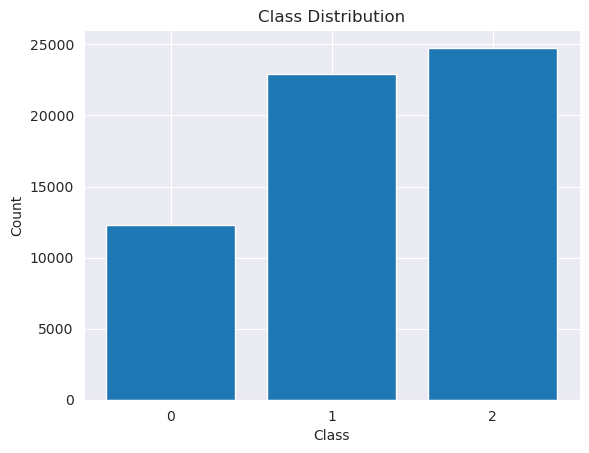

In [59]:
class_counts = pd.Series(y_train).value_counts()

# Create a bar chart to visualize the class distribution
plt.bar(class_counts.index, class_counts.values)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(class_counts.index)
plt.show()

In [60]:
model3 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote',SMOTE(random_state=SEED)),
    ('Classifier', XGBClassifier())
])

model3.fit(X_train,y_train)

y_pred = model3.predict(X_train)

print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       0.64      0.44      0.52     12275
           1       0.51      0.59      0.55     22943
           2       0.65      0.65      0.65     24763

    accuracy                           0.58     59981
   macro avg       0.60      0.56      0.57     59981
weighted avg       0.59      0.58      0.58     59981



In [61]:
level_0_models = models

level_1_model = models['XGB']

In [62]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

model4 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('stacking',StackingClassifier( estimators=list(level_0_models.items()), final_estimator=level_1_model, 
    passthrough=True, cv=cv, stack_method="predict_proba"))
])

model4.fit(X_train,y_train)

y_pred = model4.predict(X_train)

print(classification_report(y_train,y_pred))


              precision    recall  f1-score   support

           0       0.67      0.47      0.55     12275
           1       0.54      0.62      0.58     22943
           2       0.68      0.69      0.69     24763

    accuracy                           0.62     59981
   macro avg       0.63      0.59      0.61     59981
weighted avg       0.62      0.62      0.62     59981

